<a href="https://colab.research.google.com/github/zheyongnan/Advanced-Machine-Learning-Specialization/blob/master/NN_fifa_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "nn_fifa_images"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
tf.__version__

'2.6.0'

In [4]:
keras.__version__

'2.6.0'

In [6]:
import pandas as pd
dat = pd.read_csv('/FIFA_data_2002_to_2018_Zheyong_Nan.csv',header=0)

In [8]:
year = dat.loc[:,'Year']
y = dat.loc[:,['Goals']]
X = dat.iloc[:,4:]

In [9]:
X_num = X.iloc[:,6:]
from sklearn.preprocessing import StandardScaler
sd_scaler = StandardScaler()
X_num_std = sd_scaler.fit_transform(X_num)
X_num_std = pd.DataFrame(X_num_std,columns=X_num.columns)
X_final = pd.concat([X.iloc[:,:4],X_num_std],axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Goals   640 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB
None
            Goals
count  640.000000
mean     1.239062
std      1.204077
min      0.000000
25%      0.000000
50%      1.000000
75%      2.000000
max      8.000000


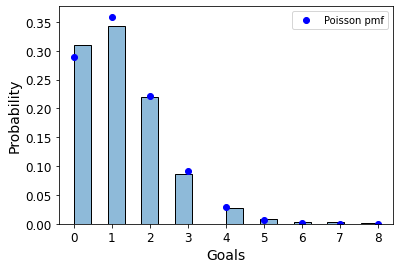

In [11]:
import seaborn as sns
print(y.info())
print(y.describe())

y_mu = np.mean(y) 
from scipy.stats import poisson
y_plot = np.arange(9)

sns.histplot(y,stat = 'probability')
plt.plot(y_plot,poisson.pmf(y_plot,y_mu),'bo',label='Poisson pmf')
plt.legend()
plt.xlabel('Goals')
# save_fig('Histograam for goals and theoritical Poisson distribution')
plt.show()

               Goals      Host  Host_oppo  ...  top_player       GDP  Population
Goals       1.000000  0.061674  -0.002486  ...    0.255450  0.139319   -0.045598
Host        0.061674  1.000000  -0.051760  ...   -0.045246  0.017086    0.090244
Host_oppo  -0.002486 -0.051760   1.000000  ...    0.030622 -0.019711   -0.092143
Conf        0.164791 -0.097223   0.051136  ...    0.262093  0.288899   -0.157145
Conf_oppo  -0.217495  0.057099  -0.085944  ...   -0.262093 -0.288899    0.157145
AVG_Age    -0.067958 -0.086878   0.088196  ...    0.096445 -0.015512    0.022531
elo         0.327313  0.006718  -0.017219  ...    0.656095  0.305614    0.109655
odds        0.248902  0.125447  -0.137695  ...    0.761426  0.065758    0.158434
top_player  0.255450 -0.045246   0.030622  ...    1.000000  0.153962    0.076111
GDP         0.139319  0.017086  -0.019711  ...    0.153962  1.000000    0.047460
Population -0.045598  0.090244  -0.092143  ...    0.076111  0.047460    1.000000

[11 rows x 11 columns]


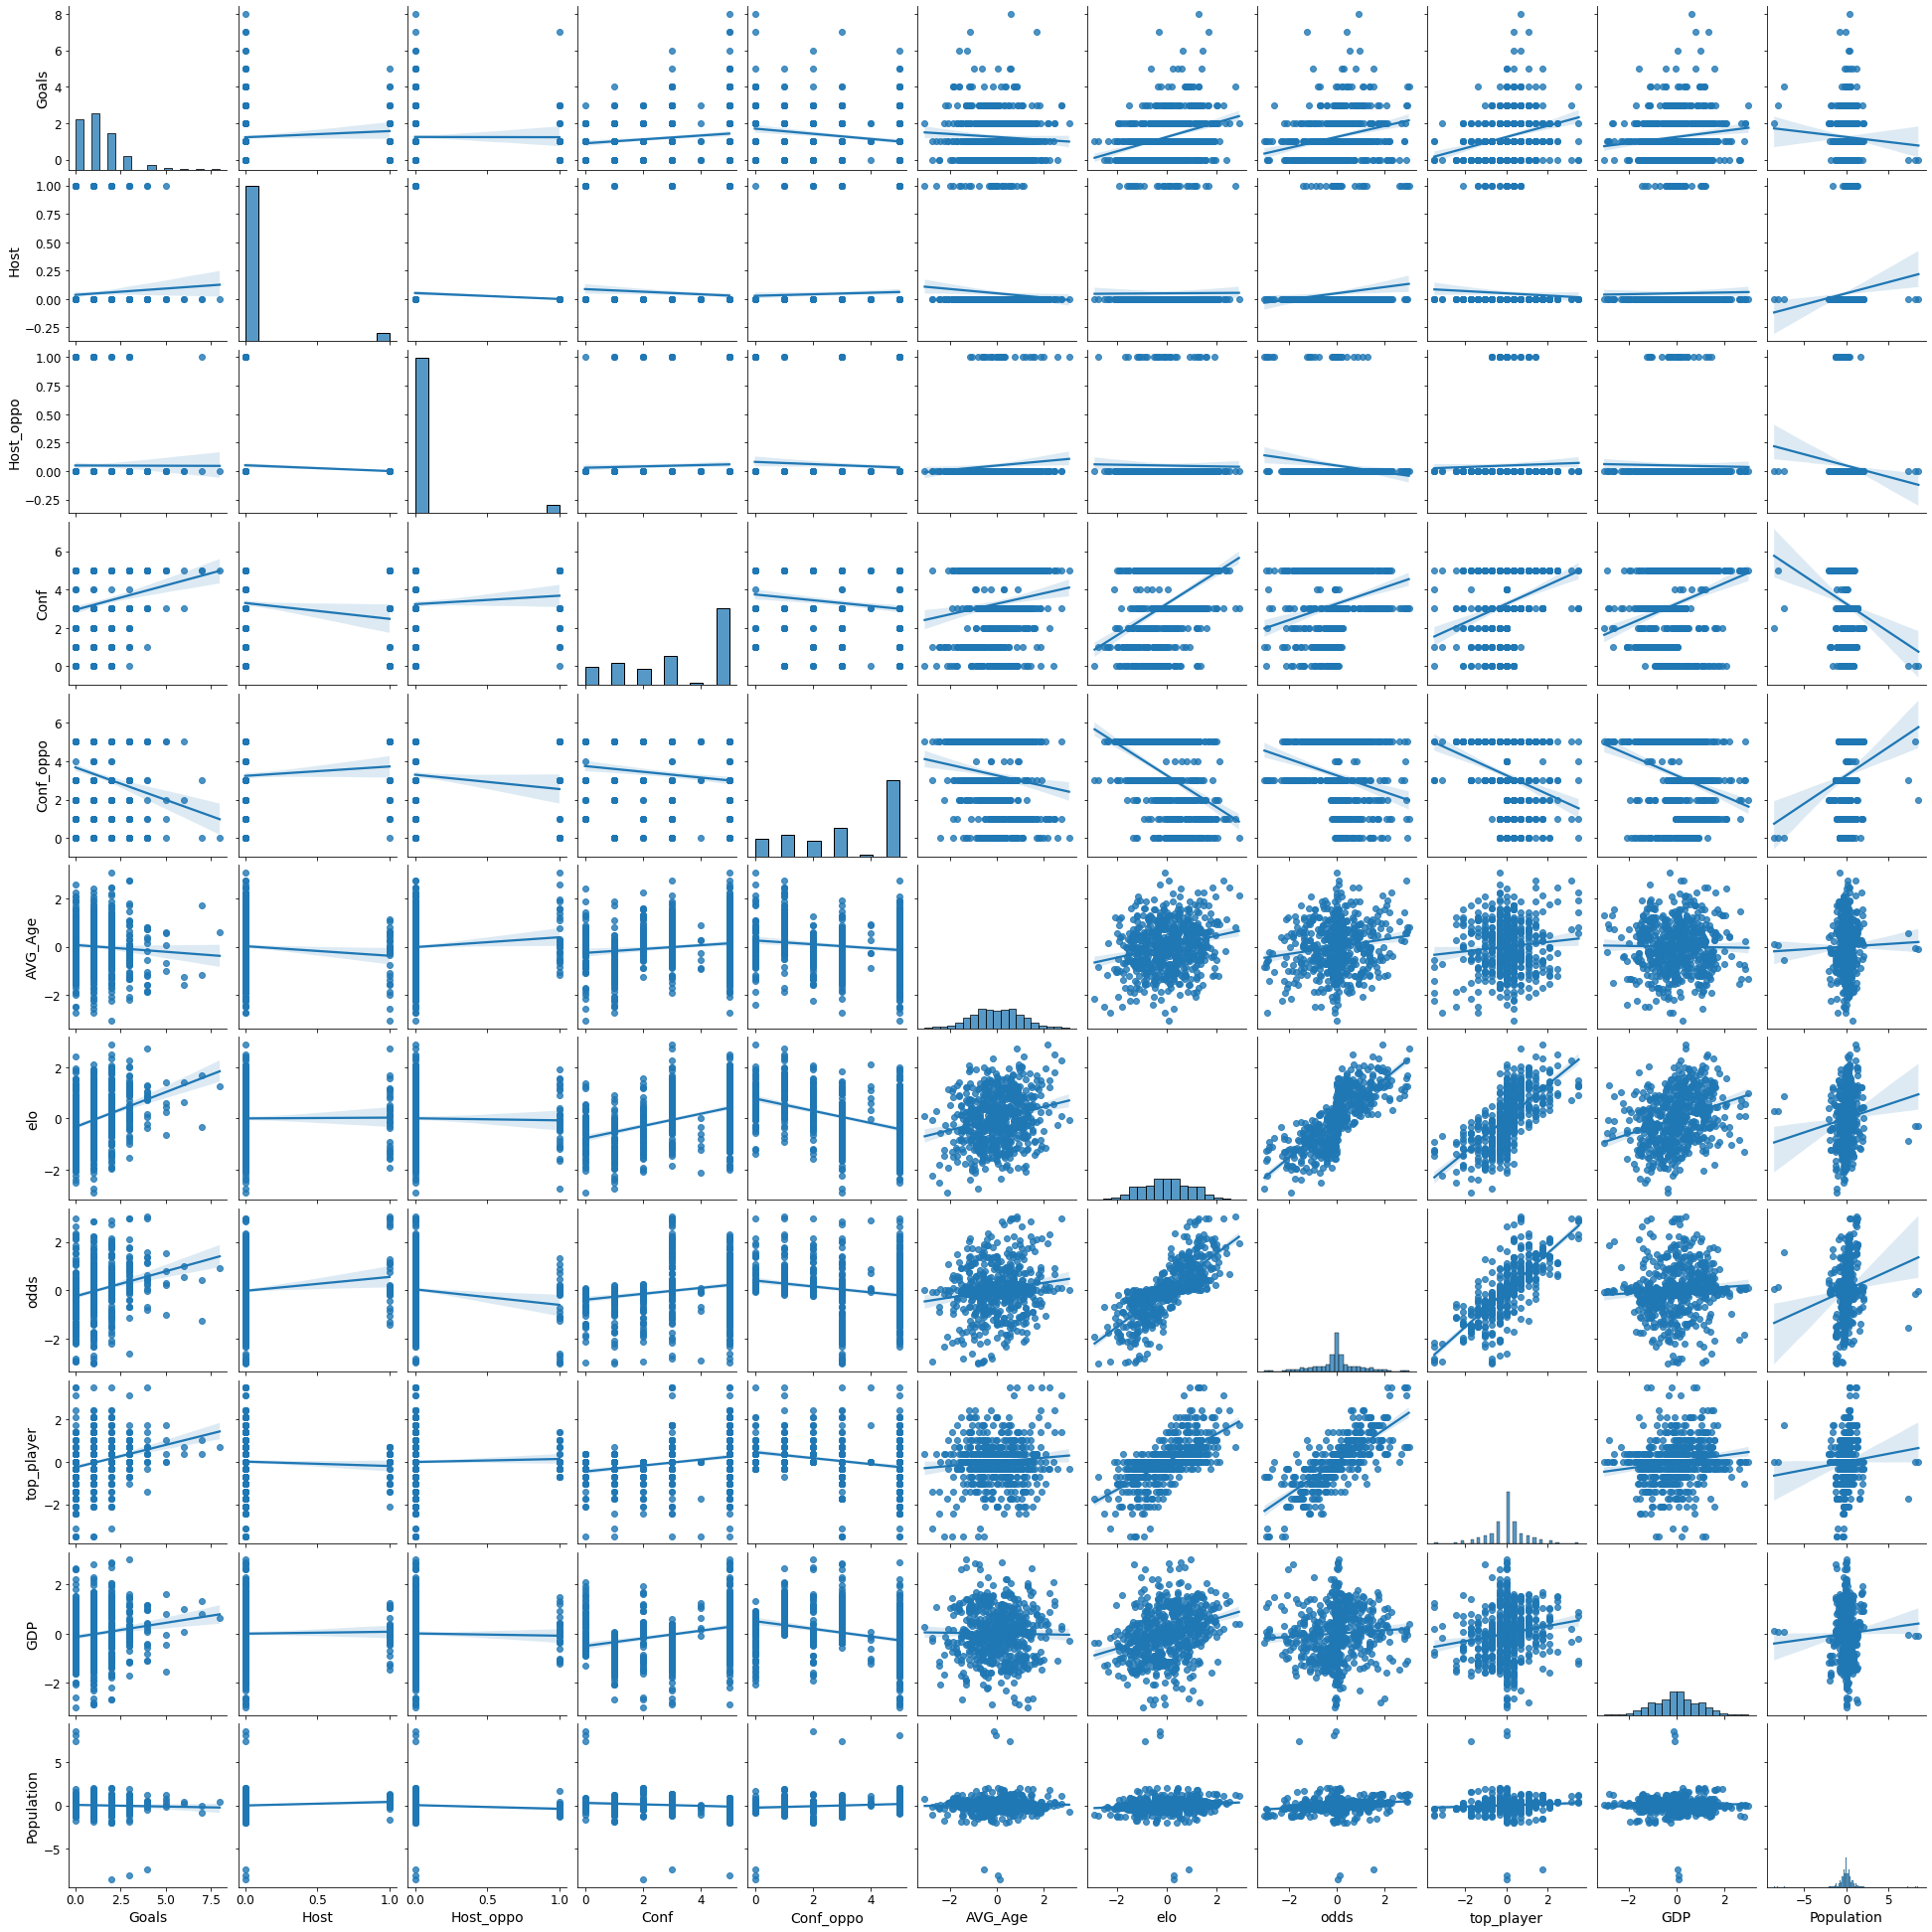

In [12]:
### correlation matrix
corr_mat = pd.concat([y,X_final],axis=1).corr()
print(corr_mat)
# corr_mat.to_csv('Correlation matrix.csv')
sns.pairplot(pd.concat([y,X_final],axis=1),kind='reg')
# save_fig('Correlation Matrix')
plt.show()

In [13]:
def error_measures(estimator,X,y,Y=None,training = True):
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_poisson_deviance
    
    if training:
        MAE = mean_absolute_error(y.loc[year!=Y,'Goals'], 
                        estimator.predict(X.loc[year!=Y,:]))
        MSE = mean_squared_error(y.loc[year!=Y,'Goals'], 
                        estimator.predict(X.loc[year!=Y,:]))
        MPD = mean_poisson_deviance(y.loc[year!=Y,'Goals'], 
                        estimator.predict(X.loc[year!=Y,:]))
        return MAE,MSE,MPD
    else:
        MAE = mean_absolute_error(y.loc[year==Y,'Goals'], 
                        estimator.predict(X.loc[year==Y,:]))
        MSE = mean_squared_error(y.loc[year==Y,'Goals'], 
                        estimator.predict(X.loc[year==Y,:]))
        MPD = mean_poisson_deviance(y.loc[year==Y,'Goals'], 
                        estimator.predict(X.loc[year==Y,:]))
        return MAE,MSE,MPD

In [14]:
def res_general(estimator,dat,X,y,Y=2018):
    y_hat = pd.DataFrame(estimator.predict(X.loc[year==Y,:]),
                         index=y.loc[year==Y,'Goals'].index)
    prediction = pd.concat([y_hat,y.loc[year==Y,'Goals'],
                                 dat.loc[year==Y,['Team_A','Team_B']]],axis=1)
    res = np.zeros(len(prediction))
    
    for i in range(0,len(res),2):
        res[i] = ((prediction.iloc[i,0] > prediction.iloc[i+1,0]
            ) and (prediction.iloc[i,1] > prediction.iloc[i+1,1])
        ) or ((prediction.iloc[i,0] < prediction.iloc[i+1,0]
            ) and (prediction.iloc[i,1] < prediction.iloc[i+1,1]))
        
        if prediction.iloc[i,1] == prediction.iloc[i+1,1]:
             res[i] = 1
        if res[i] == 1:
            res[i+1] = 1
            
    prediction['res'] = res
    
    return prediction,np.mean(res)

In [15]:
X_final.shape[1]

10

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_final.shape[1]),
    keras.layers.Dense(30, activation="relu", input_shape=X_final.shape[1]),
    keras.layers.Dense(30, activation="relu", input_shape=X_final.shape[1]),
    keras.layers.Dense(1)
])